# Flow-meter data analysis

**Here's what I'm thinking:** I was originally planning to do a [Holt-Winters analysis](https://en.wikipedia.org/wiki/Exponential_smoothing#Triple_exponential_smoothing), which is a generalization of a moving average that includes periodic and trend terms (keeping only the periodic). However, that kind of analysis assumes that the periods align; it's usually applied to day-of-week or month-of-year variations.

An important fact that even the current simulated data doesn't capture is that a patient can initiate a breath at any time. A breath will be forced after a set period of time if the patient doesn't initiate it, but we shouldn't be planning for the cases in which the breath rate is exclusively driven by the ventillator.

The most important quantities, it seems, are the inhale compliance and exhale compliance, where compliance is ΔV/ΔP, how much the lungs stretch (to fill volume) in response to applied force (pressure), because changes in compliance is what causes lung collapse and death in Covid-19 patients. Also of importance is the end-of-exhale (before the next inhale) pressure, called PEEP in the medical jargon.

Measuring volume and pressure are not difficult, but for cleaner alarms, we want to measure them at specific parts of the cycle: the active inhale leg of the cycle, the active exhale leg of the cycle, and in between those two. **I think that the most important task is to identify the legs of the cycle, despite the fact that breaths may start at any time.**

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import os
os.chdir("..")
import sim.sim

Get some simulated data.

In [3]:
times, breaths, flow, volume, pressure = sim.sim.make()

Volume is just the integral of flow.

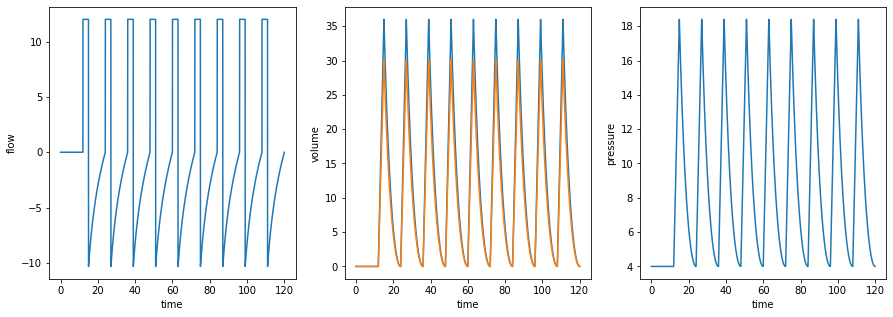

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.plot(times, flow)
ax1.set_xlabel("time")
ax1.set_ylabel("flow")

ax2.plot(times, volume)
ax2.plot(times, np.cumsum(flow) / (times[-1] - times[0]))
ax2.set_xlabel("time")
ax2.set_ylabel("volume")

ax3.plot(times, pressure)
ax3.set_xlabel("time")
ax3.set_ylabel("pressure");

These data are too regular. I can't fix the regularity of the breathing, but I can generally "fuzz" the points, dropping random ones and smearing their values.

How much should they be fuzzed? I don't know! But it's more the procedure that counts at this stage.

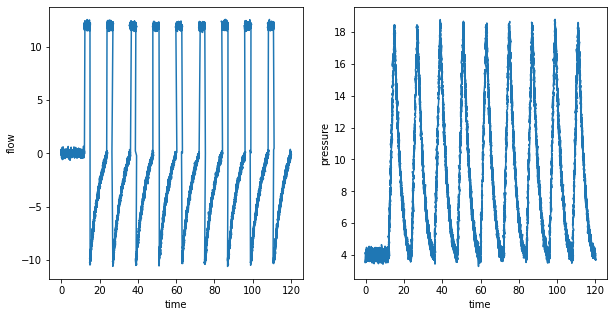

In [9]:
def fuzz(times, flow, pressure):
    mask = np.random.randint(0, 5, len(times)) != 0
    length = np.count_nonzero(mask)
    times = times[mask] + np.random.normal(0, 0.2, length)
    flow = flow[mask] + np.random.normal(0, 0.2, length)
    pressure = pressure[mask] + np.random.normal(0, 0.2, length)
    return times, flow, pressure

fuzzed_times, fuzzed_flow, fuzzed_pressure = fuzz(times, flow, pressure)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(fuzzed_times, fuzzed_flow)
ax1.set_xlabel("time")
ax1.set_ylabel("flow")
ax2.plot(fuzzed_times, fuzzed_pressure)
ax2.set_xlabel("time")
ax2.set_ylabel("pressure");

Next, I'm going to apply a smoothing procedure to fix the fuzz.

This is not just to deal with noise; it's also to turn the data from what is essentially a scatter-plot into what is essentially a curve. The smoothed function can be sampled as finely as we want, not limited by the granularity of the data, so this is a change in data type from points to a function.

My favorite technique is [local regression](https://en.wikipedia.org/wiki/Local_regression), which is normally thought of as an expensive procedure—like k-nearest neighbor, you have to search for points near $x$ for every $f(x)$ evaluation—but we can reuse searches by computing them all in a rolling pass. Unlike nearest neighbor, which takes a mean of points in a region, this takes a linear fit (which is itself a generalization of a mean). With a smooth weighting kernel (e.g. Gaussian), the end result is not linear or even piecewise linear, but everywhere smooth.

**Better still, for this project, we can get *derivatives* of the smoothed function at all points.**

But first, we need the data to be sorted so that the one-pass search works.

In [10]:
data = list(zip(*fuzz(times, flow, pressure)))
data.sort(key=lambda x: x[0])

Here's the smoothing procedure. We make arrays for the sampled results to go, step through the sorted data, and ensure that a sliding window is full of points within `±3*sig` of the sample point `t`.

The weighting function is proportional to a Gaussian with sigma `sig` (normalization is unimportant).

We repeatedly perform linear fits of the data in the window: the `intercept` is the value of the smooth function and `slope` is its derivative.

In [11]:
sig = 0.4
smoothed_start = 0.0
smoothed_stop = 120.0
smoothed_steps = int(100*(smoothed_stop - smoothed_start))

smoothed_times = np.linspace(smoothed_start, smoothed_stop, smoothed_steps)
smoothed_flow = np.zeros(len(smoothed_times))
smoothed_dflow = np.zeros(len(smoothed_times))
smoothed_pressure = np.zeros(len(smoothed_times))
smoothed_dpressure = np.zeros(len(smoothed_times))

def linear_fit(w, x, y):
    sumw   = np.sum(w)
    sumwx  = np.sum(w * x)
    sumwy  = np.sum(w * y)
    sumwxx = np.sum(w * x * x)
    sumwxy = np.sum(w * x * y)
    delta     = (sumw*sumwxx) - (sumwx*sumwx)
    intercept = ((sumwxx*sumwy) - (sumwx*sumwxy)) / delta
    slope     = ((sumw*sumwxy) - (sumwx*sumwy)) / delta
    return intercept, slope

window_times = []
window_flow = []
window_pressure = []
data_i = 0
for i, t in enumerate(smoothed_times):
    # window contains all data ±3*sig of t
    while data_i < len(data) and data[data_i][0] < t + 3*sig:
        window_times.append(data[data_i][0])
        window_flow.append(data[data_i][1])
        window_pressure.append(data[data_i][2])
        data_i += 1
    while len(window_times) > 0 and window_times[0] < t - 3*sig:
        window_times.pop(0)
        window_flow.pop(0)
        window_pressure.pop(0)

    win_times    = np.array(window_times) - t
    win_flow     = np.array(window_flow)
    win_pressure = np.array(window_pressure)

    # weighting kernel: Gaussian
    win_weights = np.exp(-0.5 * win_times**2 / sig**2)

    smoothed_flow[i],     smoothed_dflow[i]     = linear_fit(win_weights, win_times, win_flow)
    smoothed_pressure[i], smoothed_dpressure[i] = linear_fit(win_weights, win_times, win_pressure)

The smooth function has recovered the shape of the original data (with smearing, since the fuzzing and smoothing blurred everything).

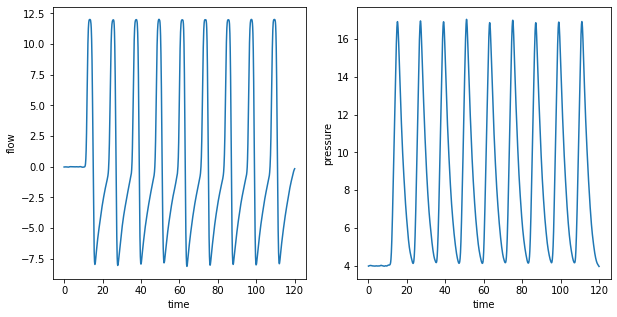

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(smoothed_times, smoothed_flow)
ax1.set_xlabel("time")
ax1.set_ylabel("flow")
ax2.plot(smoothed_times, smoothed_pressure)
ax2.set_xlabel("time")
ax2.set_ylabel("pressure");

But more importantly, we now have derivatives.

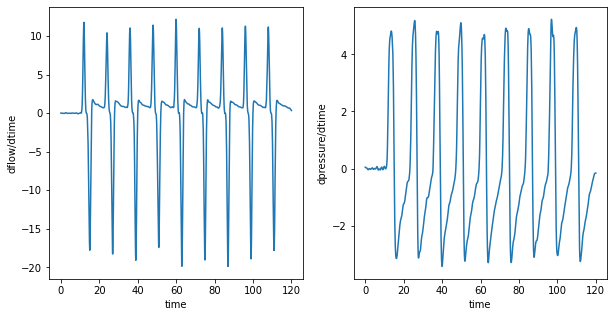

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(smoothed_times, smoothed_dflow)
ax1.set_xlabel("time")
ax1.set_ylabel("dflow/dtime")
ax2.plot(smoothed_times, smoothed_dpressure)
ax2.set_xlabel("time")
ax2.set_ylabel("dpressure/dtime");

Since volume is the integral of flow, its derivative is flow. So we have these pairs:

   * smoothed volume and its derivative (flow)
   * smoothed flow and its derivative
   * smoothed pressure and its derivative

(In the plot, we see that the integral is wandering downward; something will have to be added to the smoothing procedure to preserve integral—perhaps the smoothing must be applied in volume space, rather than flow space.)

In [17]:
smoothed_volume = np.cumsum(smoothed_flow) / (smoothed_stop - smoothed_start)

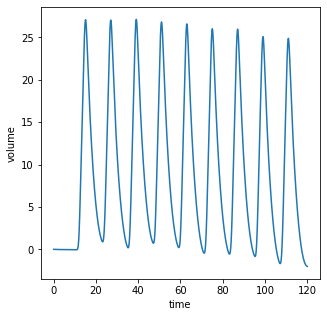

In [31]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))
ax1.plot(smoothed_times, smoothed_volume)
ax1.set_xlabel("time")
ax1.set_ylabel("volume");

We can make phase-space plots! These provide the insensitivity to when a breath starts because a temporal offset that doesn't affect the shape of a breath as a function of time draws the same curve in this phase space.

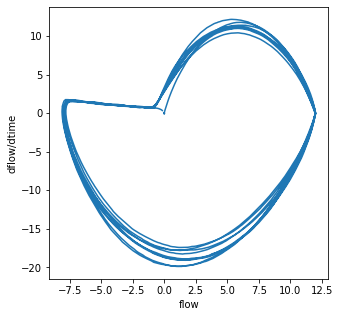

In [15]:
# Phase space cycle for flow
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(smoothed_flow, smoothed_dflow)
ax.set_xlabel("flow")
ax.set_ylabel("dflow/dtime");

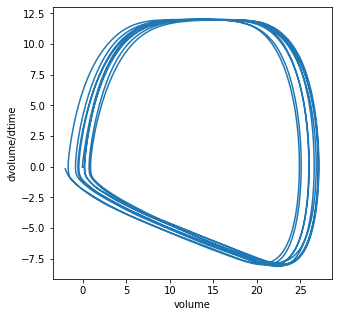

In [18]:
# Phase space cycle for volume
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(smoothed_volume, smoothed_flow)
ax.set_xlabel("volume")
ax.set_ylabel("dvolume/dtime");

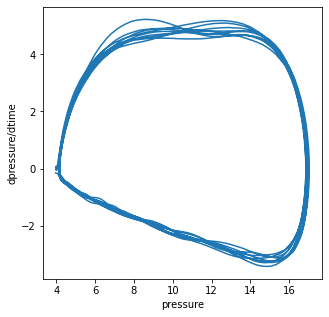

In [19]:
# Phase space cycle for pressure
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(smoothed_pressure, smoothed_dpressure)
ax.set_xlabel("pressure")
ax.set_ylabel("dpressure/dtime");

It's encouraging that the volume and pressure phase cycles have roughly the same shapes, since that indicates constant compliance (ΔV/ΔP), which is the case for this artificial dataset.

The task is to select the legs of this cycle based on their shape and not their absolute time. The fact that these are roughly straight edges suggests that we'll see these slopes as peaks in a histogram of derivative-divided-by-value.

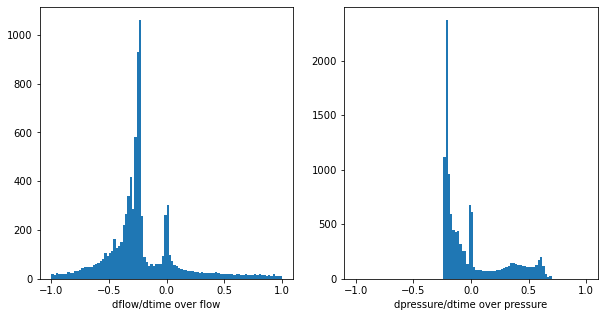

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(smoothed_dflow / smoothed_flow, bins=100, range=(-1, 1))
ax1.set_xlabel("dflow/dtime over flow")
ax2.hist(smoothed_dpressure / smoothed_pressure, bins=100, range=(-1, 1))
ax2.set_xlabel("dpressure/dtime over pressure");

The central peak at zero of the left plot (where the flow derivative is nearly independent of its
value) is the inhale stroke, which is very regular in this simulation because it is modeled as being forced by the ventillator.

In [22]:
#                       central peak of the left plot              positive flow
inhale = np.logical_and(abs(smoothed_dflow / smoothed_flow) < 0.2, smoothed_flow > 1)

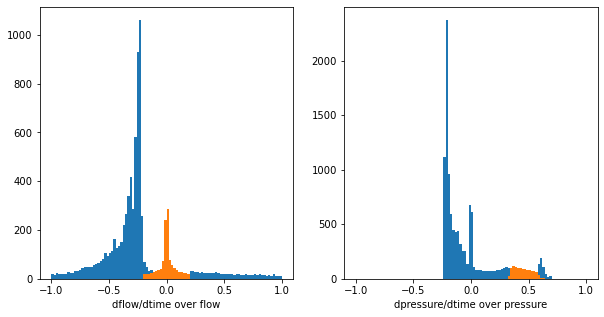

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(smoothed_dflow[~inhale] / smoothed_flow[~inhale], bins=100, range=(-1, 1))
ax1.hist(smoothed_dflow[inhale] / smoothed_flow[inhale], bins=100, range=(-1, 1))
ax1.set_xlabel("dflow/dtime over flow")
ax2.hist(smoothed_dpressure[~inhale] / smoothed_pressure[~inhale], bins=100, range=(-1, 1))
ax2.hist(smoothed_dpressure[inhale] / smoothed_pressure[inhale], bins=100, range=(-1, 1))
ax2.set_xlabel("dpressure/dtime over pressure");

The negative peak of the left plot (where the flow derivative is roughly a constant with respect to its value) is the exhale stroke.

In [25]:
#                       negative peak of the left plot                        negative flow
exhale = np.logical_and(abs(-0.25 - (smoothed_dflow / smoothed_flow)) < 0.15, smoothed_flow < -1)

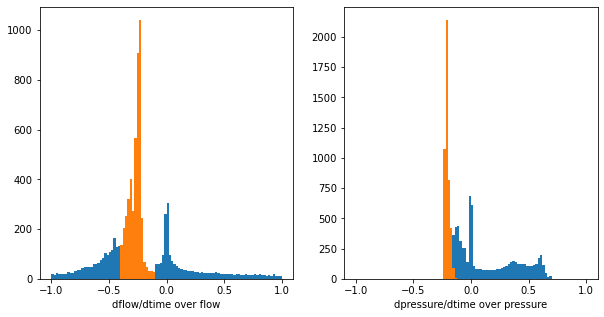

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(smoothed_dflow[~exhale] / smoothed_flow[~exhale], bins=100, range=(-1, 1))
ax1.hist(smoothed_dflow[exhale] / smoothed_flow[exhale], bins=100, range=(-1, 1))
ax1.set_xlabel("dflow/dtime over flow")
ax2.hist(smoothed_dpressure[~exhale] / smoothed_pressure[~exhale], bins=100, range=(-1, 1))
ax2.hist(smoothed_dpressure[exhale] / smoothed_pressure[exhale], bins=100, range=(-1, 1))
ax2.set_xlabel("dpressure/dtime over pressure");

To show that these are, in fact, the right legs of the cycle, I'll apply the same cut to the time series and phase-space plots.

First, the inhale leg:

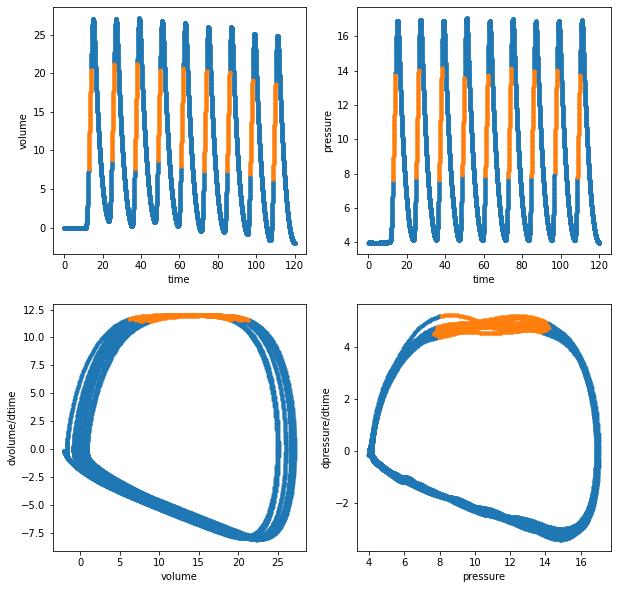

In [29]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

ax1.plot(smoothed_times[~inhale], smoothed_volume[~inhale], ".")
ax1.plot(smoothed_times[inhale], smoothed_volume[inhale], ".")
ax1.set_xlabel("time")
ax1.set_ylabel("volume")

ax2.plot(smoothed_times[~inhale], smoothed_pressure[~inhale], ".")
ax2.plot(smoothed_times[inhale], smoothed_pressure[inhale], ".")
ax2.set_xlabel("time")
ax2.set_ylabel("pressure")

ax3.plot(smoothed_volume[~inhale], smoothed_flow[~inhale], ".")
ax3.plot(smoothed_volume[inhale], smoothed_flow[inhale], ".")
ax3.set_xlabel("volume")
ax3.set_ylabel("dvolume/dtime")

ax4.plot(smoothed_pressure[~inhale], smoothed_dpressure[~inhale], ".")
ax4.plot(smoothed_pressure[inhale], smoothed_dpressure[inhale], ".")
ax4.set_xlabel("pressure")
ax4.set_ylabel("dpressure/dtime");

Then, the exhale leg:

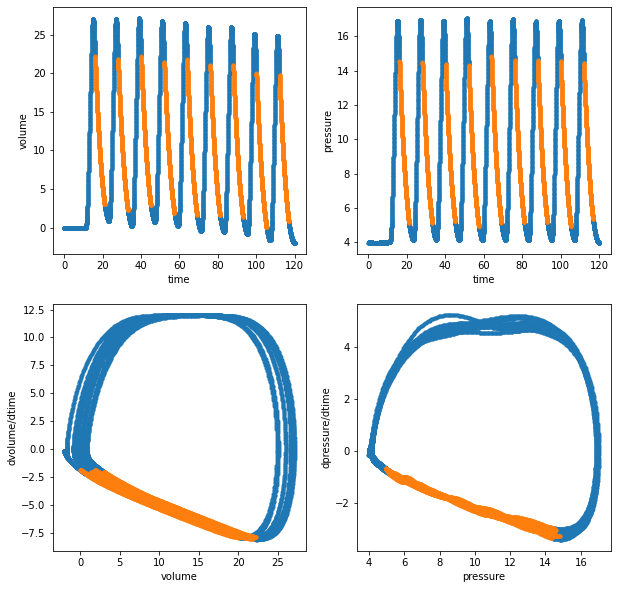

In [30]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

ax1.plot(smoothed_times[~exhale], smoothed_volume[~exhale], ".")
ax1.plot(smoothed_times[exhale], smoothed_volume[exhale], ".")
ax1.set_xlabel("time")
ax1.set_ylabel("volume")

ax2.plot(smoothed_times[~exhale], smoothed_pressure[~exhale], ".")
ax2.plot(smoothed_times[exhale], smoothed_pressure[exhale], ".")
ax2.set_xlabel("time")
ax2.set_ylabel("pressure")

ax3.plot(smoothed_volume[~exhale], smoothed_flow[~exhale], ".")
ax3.plot(smoothed_volume[exhale], smoothed_flow[exhale], ".")
ax3.set_xlabel("volume")
ax3.set_ylabel("dvolume/dtime")

ax4.plot(smoothed_pressure[~exhale], smoothed_dpressure[~exhale], ".")
ax4.plot(smoothed_pressure[exhale], smoothed_dpressure[exhale], ".")
ax4.set_xlabel("pressure")
ax4.set_ylabel("dpressure/dtime");

With these cuts, we can ask about compliance in the inhale separately from the exhale.

Compliance = ΔV/ΔP = (ΔV/Δt)/(ΔP/Δt) = flow/(ΔP/Δt).

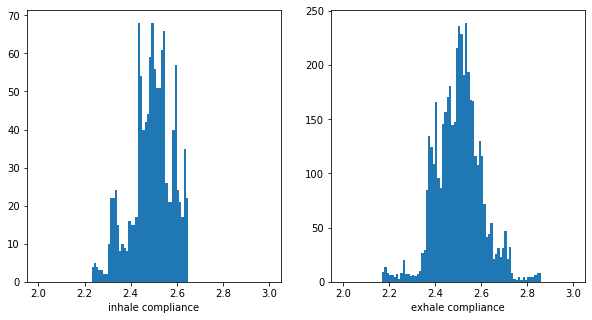

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(smoothed_flow[inhale]/smoothed_dpressure[inhale], bins=100, range=(2, 3))
ax1.set_xlabel("inhale compliance")
ax2.hist(smoothed_flow[exhale]/smoothed_dpressure[exhale], bins=100, range=(2, 3))
ax2.set_xlabel("exhale compliance");

They happen to be the same in this simulation, but if they differed, we would be able to cleanly separate the histograms.